<a href="https://colab.research.google.com/github/troncosofranco/IoT-Spark/blob/main/Wind_Turbine_Power_w_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wind Turbine Power Prediction

##Scope
In this project, the wind turbine power is modeled considering multiple features (wind speed, wind direction, month and hour data). The Exploratory Data Analysis (EDA) and data modeling is performed deploying Pyspark library

##Dataset
The dataset was obtained from [Kaggle Repository](https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset). In Wind Turbines, Scada Systems measure and save data's. The dataset presents the following attributes:
- **Date/Time** (for 10 minutes intervals)
- **LV ActivePower (kW):** The power generated by the turbine for that moment
- **Wind Speed (m/s):** The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation).
- **TheoreticalPowerCurve (KWh):** The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- **Wind Direction (°):** The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly).

##Objective
Determination of wind turbine power production as function of wind speed, wind direction, and Date/Time.



#1. Import modules

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 199 kB 53.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=e17abae45f977c286703b25d61bb43f3858baaf4f71fabbba16f0ccb8ec5ce03
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [2]:
# Import pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

#Spark session configuration 
spark = SparkSession.builder.master("local").appName("wind_turbine_power").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local appName=wind_turbine_power>

#2. Load Dataset

In [3]:
#load dataset
df = spark.read.csv('Turbine.csv', header=True, inferSchema=True)

#dataset in cache
df.cache()

DataFrame[Date/Time: string, LV ActivePower (kW): double, Wind Speed (m/s): double, Theoretical_Power_Curve (KWh): double, Wind Direction (°): double]

In [4]:
#colum names to lower case
df = df.toDF(*[c.lower() for c in df.columns]) #to dataframe
df.show(10)

+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
|01 01 2018 00:50|   402.391998291015|5.60405206680297|             499.436385024805|   264.57861328125|
|01 01 2018 01:00|   447.605712890625|5.79300785064697|

In [5]:
#datatype
df.printSchema()

root
 |-- date/time: string (nullable = true)
 |-- lv activepower (kw): double (nullable = true)
 |-- wind speed (m/s): double (nullable = true)
 |-- theoretical_power_curve (kwh): double (nullable = true)
 |-- wind direction (°): double (nullable = true)



In [6]:
#number of observation or instances
df.count()

50530

In [7]:
#Decompose timeseries in year, month and hour variables
from pyspark.sql.functions import substring 

#date/time: string
df = df.withColumn('month', substring('date/time',4,2))
#df = df.withColumn('year', substring('date/time',7,4))
df = df.withColumn('hour', substring('date/time',12,2))
df = df.withColumn('min', substring('date/time',15,2))

#min, hour, month and year to integer
from pyspark.sql.types import IntegerType

df = df.withColumn('month', df.month.cast(IntegerType()))
df = df.withColumn('hour', df.hour.cast(IntegerType()))
df = df.withColumn('min', df.min.cast(IntegerType()))
#df = df.withColumn('year', df.year.cast(IntegerType()))
df.show(10)
df.printSchema()

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+---+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|min|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+---+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|  0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0| 10|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0| 20|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0| 30|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0| 40|
|01 01 2018 00:50|   402.391998291015|5.

#2. Exploratory Data Analysis (EDA)

##2.1. Summary

In [8]:
#spark dataframe to pandas dataframe
pd.options.display.float_format = '{:.2f}'.format
df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)',
          'month','hour','min').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw),month,hour,min
count,50530.00,50530.00,50530.00,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68,6.51,11.52,25.00
std,4.23,1368.02,1312.46,3.41,6.93,17.08
min,0.00,0.00,-2.47,1.00,0.00,0.00
25%,4.20,161.33,50.68,4.00,5.00,10.00
50%,7.10,1063.78,825.84,6.00,12.00,20.00
75%,10.30,2964.97,2482.51,9.00,18.00,40.00
max,25.21,3600.00,3618.73,12.00,23.00,50.00


#2.2. Feature distribution

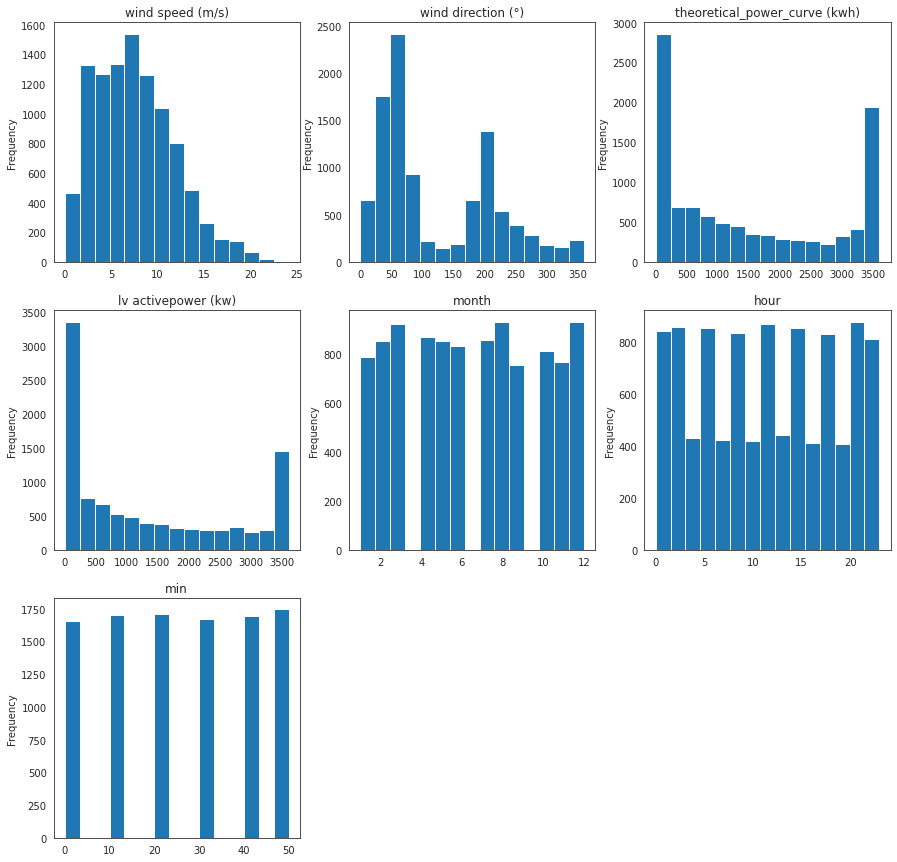

In [9]:
#Get sample of big data for EDA
df_sample = df.sample(withReplacement=False, fraction=0.2, seed=42).toPandas()

#plot the feature distribution
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)','month', 'hour','min']
i=1
plt.figure(figsize=(15,15))
for column in columns:
    plt.subplot(3,3,i)
    df_sample[column].plot.hist(bins=15)
    plt.title(column)
    i += 1

#3. Data visualization

##3.1. Feature average by month

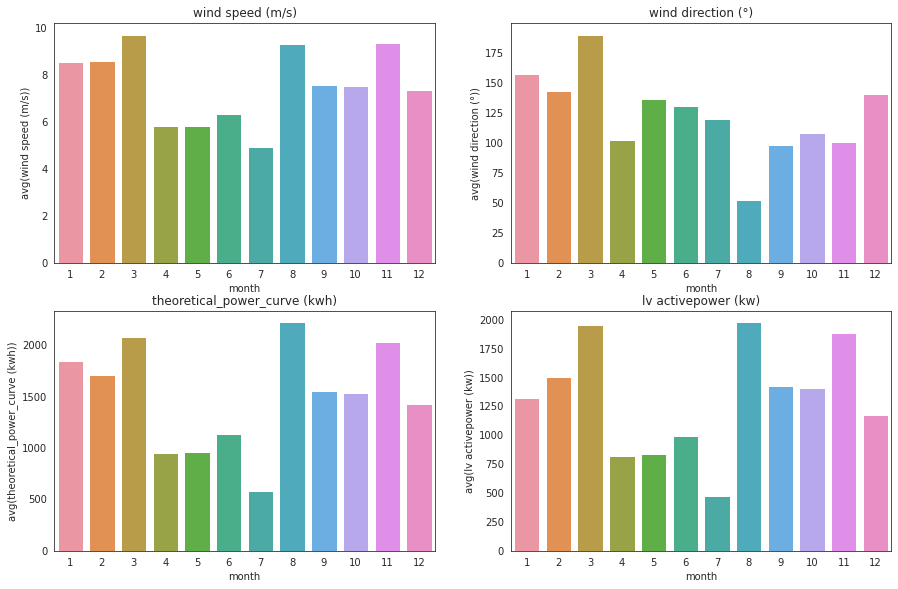

In [10]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']

i=1
plt.figure(figsize=(15,15))
for column in columns:
    plt.subplot(3,2,i)
    monthly_avg = df.groupby('month').mean(column).sort('avg(' + column + ')').toPandas()
    sns.barplot(x='month', y='avg(' + column + ')', data=monthly_avg)
    plt.title(column)
    i += 1





##3.2. Feature average by hour

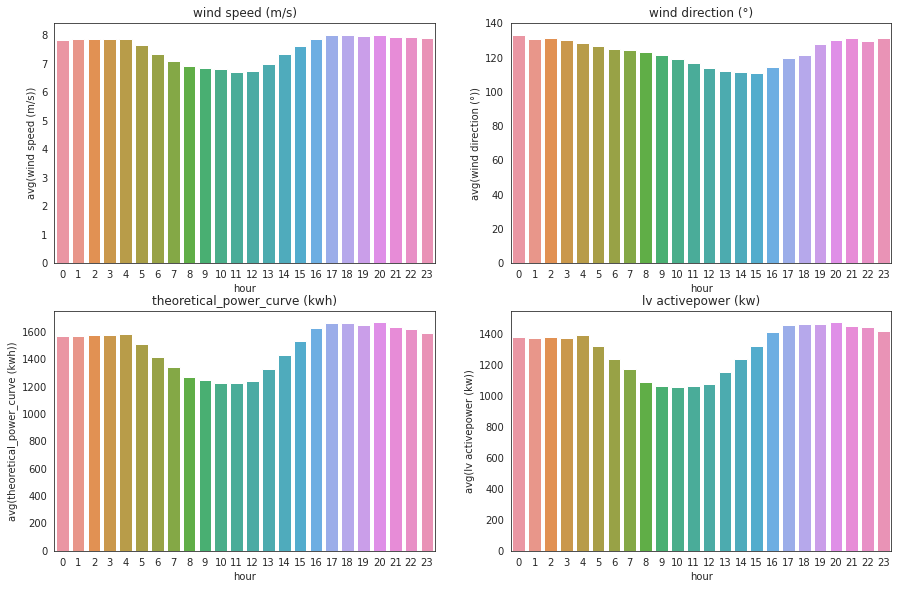

In [11]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']

i=1
plt.figure(figsize=(15,15))
for column in columns:
    plt.subplot(3,2,i)
    monthly_avg = df.groupby('hour').mean(column).sort('avg(' + column + ')').toPandas()
    sns.barplot(x='hour', y='avg(' + column + ')', data=monthly_avg)
    plt.title(column)
    i += 1

##3.3. Correlation heatmap

In [12]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)','month','hour','min']
display(df_sample[columns].corr())

,wind speed (m/s),wind direction (°),theoretical_power_curve (kwh),lv activepower (kw),month,hour,min
wind speed (m/s),1.00,-0.07,0.94,0.91,-0.02,0.02,-0.01
wind direction (°),-0.07,1.00,-0.10,-0.06,-0.17,-0.01,0.01
theoretical_power_curve (kwh),0.94,-0.10,1.00,0.95,-0.00,0.03,-0.00
lv activepower (kw),0.91,-0.06,0.95,1.00,0.03,0.03,-0.01
month,-0.02,-0.17,-0.00,0.03,1.00,0.00,-0.00
hour,0.02,-0.01,0.03,0.03,0.00,1.00,0.01
min,-0.01,0.01,-0.00,-0.01,-0.00,0.01,1.00


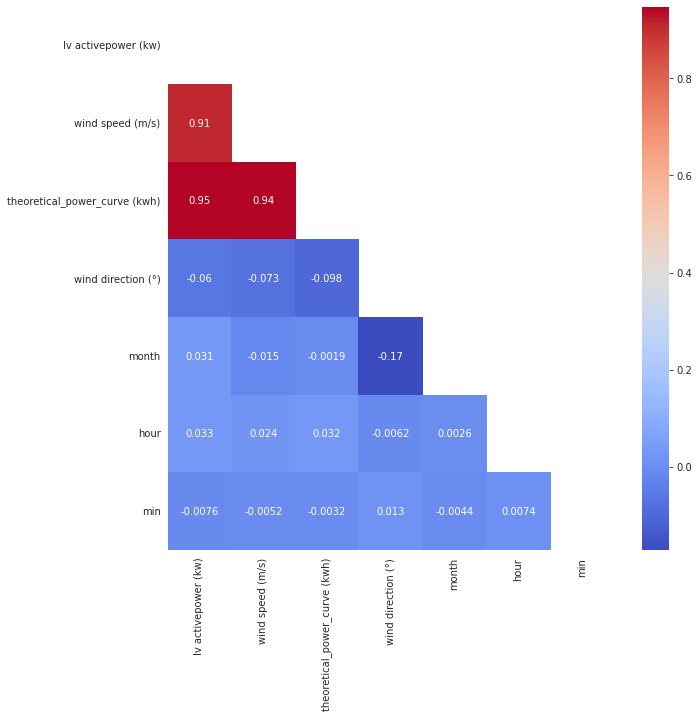

In [13]:
def corr_heatmap(df):
  df_corr = df.corr(method = 'pearson')
  mask = np.triu(np.ones_like(df.corr()))
  fig, ax = plt.subplots(figsize=(10,10)) 
  sns.heatmap(df_corr, cmap="coolwarm", annot=True, mask= mask, ax=ax)
  plt.show()

corr_heatmap(df_sample)

The theoretical power curve and active power are strongly correlated with wind speed, and no with time variables or wind direction.

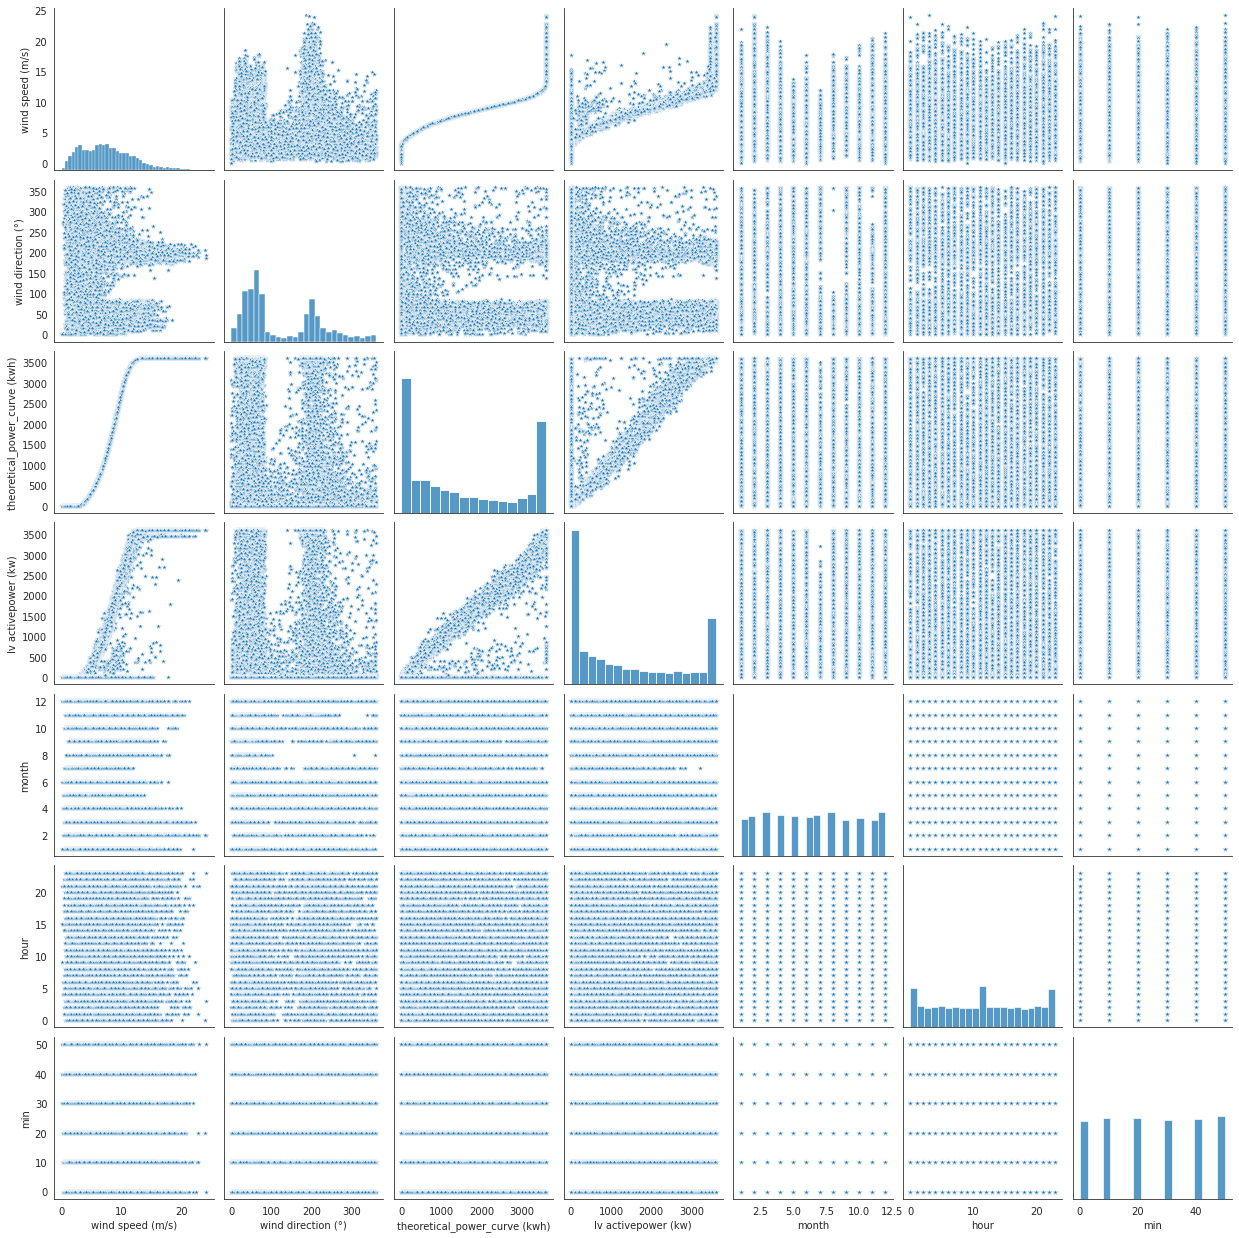

In [14]:
sns.pairplot(df_sample[columns], markers='*');

In the previous pairplot is also observed the strong correlation between `lv activepower (kw)` and `theoretical_power_curve (kwh)` with `wind speed (m/s)`. As can be observed, `lv activepower (kw)` and `theoretical_power_curve (kwh)` shows a similar behaviour as function of `wind direction (°)`

##3.4. Power Production vs wind features

###3.4.1. Wind speed

According to summary section, the range of wind speed is between 0 and 25.21 m/s.

Text(0.5, 0, 'Wind Speed (m/s)')

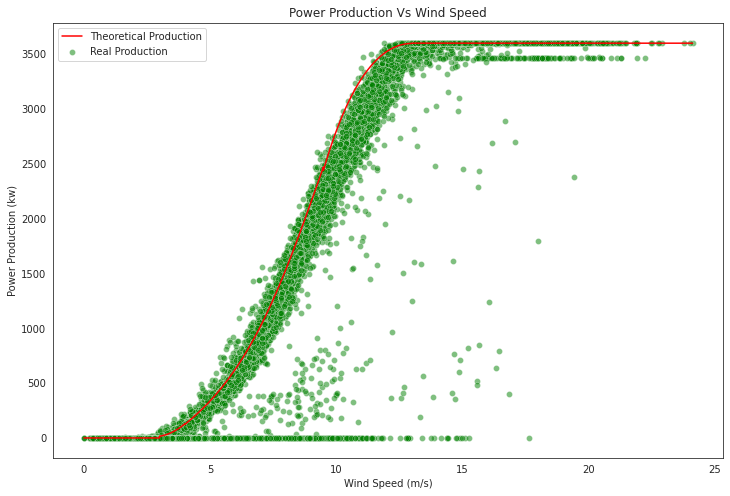

In [15]:
plt.figure(figsize=(12,8))

#scatter plot
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='green', label='Real Production', alpha=0.5, data=df_sample)

#lineplot
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='red', label='Theoretical Production', data=df_sample)
plt.title('Power Production Vs Wind Speed')
plt.ylabel('Power Production (kw)')
plt.xlabel('Wind Speed (m/s)')

From the previous figure, the following observations can be made:
- The theoretical power production satisfactory reproduce the real power production behavior.
- The real power production shows an asymptotic behavior for higher wind speed value than 13 m/s, approximately.
- Zero values of real power production occurs in a broad range of wind speed


Text(0, 0.5, 'Counts for 0 Real and Teoretical Power Production')

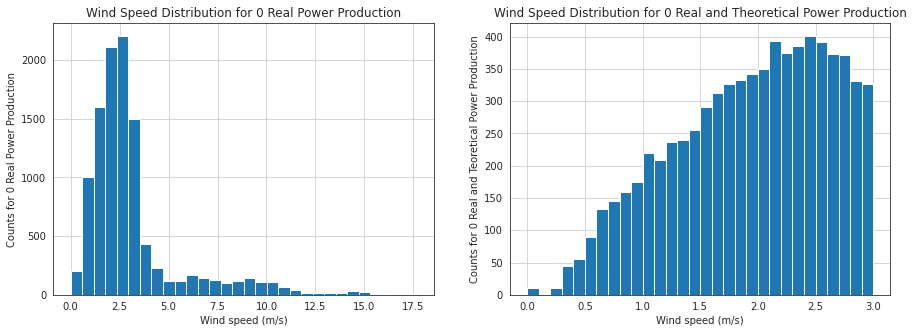

In [16]:
#zero values real production distribution as function of wind speed
plt.figure(figsize=(15,5))

df_zero = df.filter(df['lv activepower (kw)']==0).toPandas()
plt.subplot(1,2,1)
df_zero['wind speed (m/s)'].hist(bins=30)
plt.title('Wind Speed Distribution for 0 Real Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Real Power Production')

#zero values real production and theoretical distribution as function of wind speed
df_zero = df.filter((df['lv activepower (kw)']==0) & (df['theoretical_power_curve (kwh)']==0)).toPandas()
#df_zero = df.filter(df['theoretical_power_curve (kwh)']==0).toPandas()
plt.subplot(1,2,2)
df_zero['wind speed (m/s)'].hist(bins=30)
plt.title('Wind Speed Distribution for 0 Real and Theoretical Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Real and Teoretical Power Production')

The majority of 0 values for real power production occurs to a wind speed from 0.5 to 4 m/s. On the other hand, for zero real and theorical power production, the maximum value observed was 3.0 m/s. This indicates the minimum speed to generate theorical power production. Fuerthermore, also no real power production was observed at wind speed higher than 3.0 m/s. This could be attributed to maintenance or other operative behavior of the wind turbine. Thus, the monthly distribution of zero power production is analyzed.

In [17]:
#zero power production distribution

Text(0, 0.5, 'Counts for 0 Real and Teoretical Power Production')

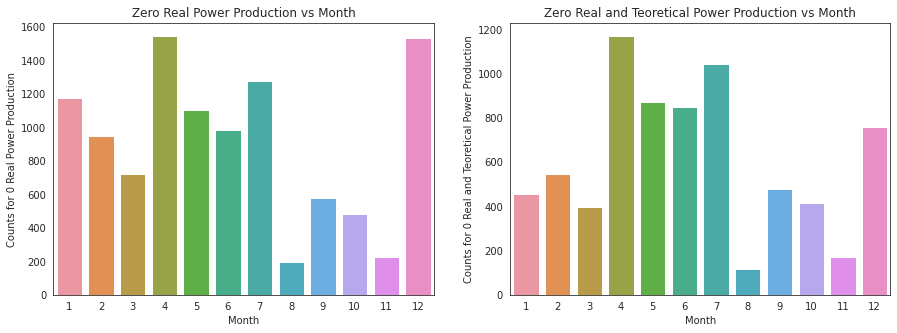

In [18]:
plt.figure(figsize=(15,5))

df_zero = df.filter((df['lv activepower (kw)']==0) & (df['wind speed (m/s)']!=0)).toPandas()
plt.subplot(1,2,1)
sns.countplot(df_zero['month'])
plt.title('Zero Real Power Production vs Month')
plt.xlabel('Month')
plt.ylabel('Counts for 0 Real Power Production')

#zero values real production and theoretical distribution as function of wind speed
df_zero = df.filter((df['lv activepower (kw)']==0) & (df['theoretical_power_curve (kwh)']==0) & (df['wind speed (m/s)']!=0)).toPandas()
plt.subplot(1,2,2)
sns.countplot(df_zero['month'])
plt.title('Zero Real and Teoretical Power Production vs Month')
plt.xlabel('Month')
plt.ylabel('Counts for 0 Real and Teoretical Power Production')

The major amount of zero counts of real power production were observed on April and December, followed by January (wind speed > 0). Regarding zero real and theorical power production, the highest zetro count was observed on April, followed by July and December.

Text(0, 0.5, 'Counts for 0 Real and Teoretical Power Production')

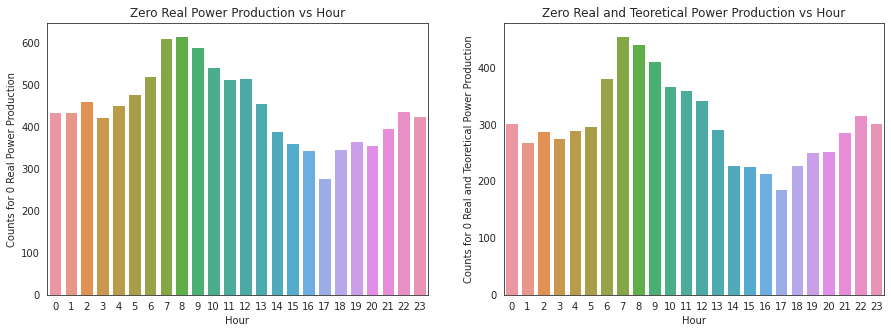

In [19]:
plt.figure(figsize=(15,5))

df_zero = df.filter((df['lv activepower (kw)']==0) & (df['wind speed (m/s)']!=0)).toPandas()
plt.subplot(1,2,1)
sns.countplot(df_zero['hour'])
plt.title('Zero Real Power Production vs Hour')
plt.xlabel('Hour')
plt.ylabel('Counts for 0 Real Power Production')

#zero values real production and theoretical distribution as function of wind speed
df_zero = df.filter((df['lv activepower (kw)']==0) & (df['theoretical_power_curve (kwh)']==0) & (df['wind speed (m/s)']!=0)).toPandas()
plt.subplot(1,2,2)
sns.countplot(df_zero['hour'])
plt.title('Zero Real and Teoretical Power Production vs Hour')
plt.xlabel('Hour')
plt.ylabel('Counts for 0 Real and Teoretical Power Production')

The major amount of zero counts of real power production were observed between 7-9. Similar observation were found for real power and teorerical power production. 

#4. Outlier handling

Zero values of real power production assumed as outliers considering the available data.

In [20]:
df_clean = df.filter((df['lv activepower (kw)'] > 0)
                           & (df['theoretical_power_curve (kwh)'] > 0)
                          & (df['wind speed (m/s)'] > 3)).toPandas()



In [21]:
df_clean.dtypes

date/time                         object
lv activepower (kw)              float64
wind speed (m/s)                 float64
theoretical_power_curve (kwh)    float64
wind direction (°)               float64
month                              int32
hour                               int32
min                                int32
dtype: object

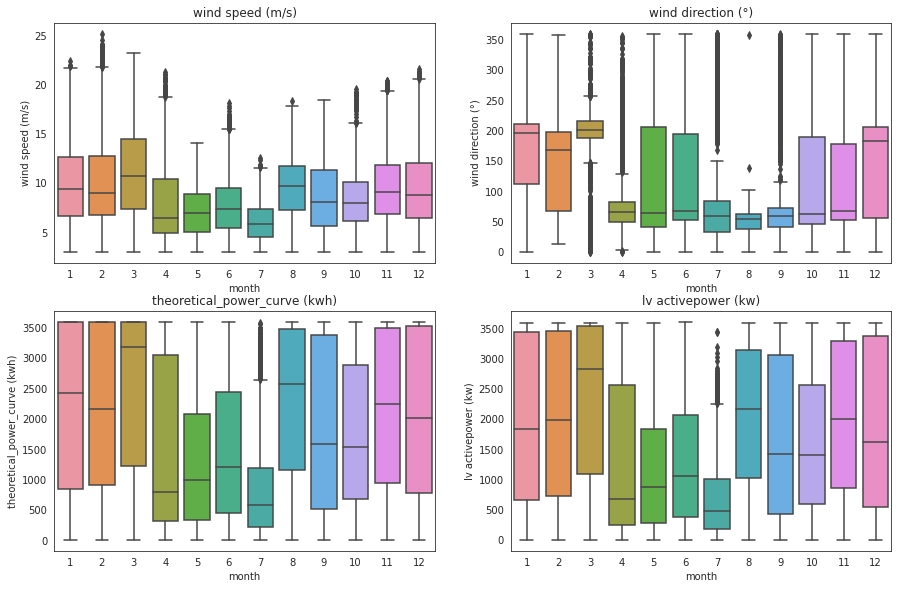

In [22]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']

i=1
plt.figure(figsize=(15,15))
for column in columns:
    plt.subplot(3,2,i)
    sns.boxplot( x=df_clean['month'], y=df_clean[column])
    plt.title(column)
    i += 1

Multiple outliers can be observed in the previous plot, mainly wind speed and direction. Real and theoretical power generation also present outliers on July.

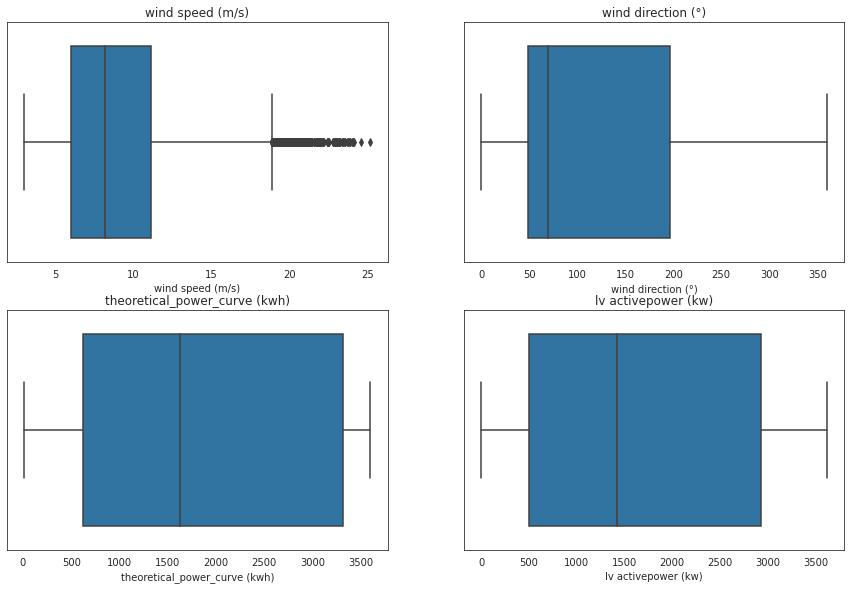

In [23]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(15,15))
for column in columns:
    plt.subplot(3,2,i)
    sns.boxplot( x=column, data=df_clean)
    plt.title(column)
    i += 1

From an overview, `wind speed` shows the highest proportion of outlier.

In [24]:
#Outliers remotion
#df_clean.describe()

#Quantiles and interquantile range
#Q1 = df_clean['wind speed (m/s)'].quantile(0.25)
#Q3 = df_clean['wind speed (m/s)'].quantile(0.75)
#IQR = Q3-Q1

#Lower and upper threshold values
#lower = Q1 - 1.5*IQR
#upper = Q3 + 1.5*IQR
#df_train = df_clean.loc[(df_clean['wind speed (m/s)'] > lower) & (df_clean['wind speed (m/s)'] < upper)]
#df_train.describe()
#df_zero = df.filter((df['lv activepower (kw)']==0) & (df['wind speed (m/s)']!=0)).toPandas()

In [25]:
#Remove outliers based on quantile
def remove_outliers(df,column):
  #Quantiles and interquantile range
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3-Q1

  #Lower and upper threshold values
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR
  return df.loc[(df[column] > lower) & (df[column] < upper)]
  
  
df_or = remove_outliers(df_clean,'wind speed (m/s)' )
df_or.describe()


,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour,min
count,38655.00,38655.00,38655.00,38655.00,38655.00,38655.00,38655.00
mean,1652.92,8.66,1821.83,113.79,6.70,11.72,24.95
std,1246.49,3.48,1290.75,86.15,3.34,6.97,17.08
min,0.03,3.00,16.07,0.00,1.00,0.00,0.00
25%,493.17,5.95,609.71,48.39,4.00,6.00,10.00
50%,1382.88,8.09,1583.15,69.30,7.00,12.00,20.00
75%,2849.08,10.98,3264.90,196.64,10.00,18.00,40.00
max,3618.73,18.88,3600.00,360.00,12.00,23.00,50.00


- Lower = 3 m/s
- Upper = 18.88 m/s

In [26]:
#set values with conditions using spark
#from pyspark.sql import functions as F
#spark_df = spark_df.withColumn('wind speed (m/s)', 
                               #F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               #otherwise(F.col('wind speed (m/s)')))


#3.4.2. Speed direction

Text(0, 0.5, '')

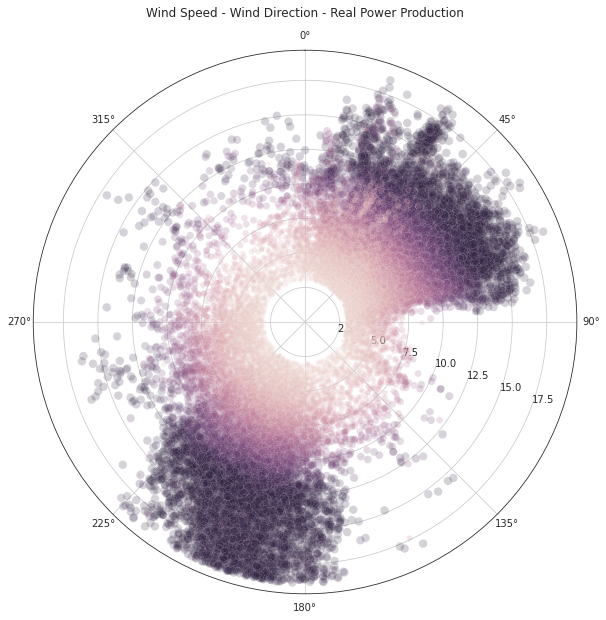

In [27]:
#Create the polar diagram for Real Power production as function of wind features
from math import radians

plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
sns.scatterplot(x=[radians(x) for x in df_or['wind direction (°)']], 
                y=df_or['wind speed (m/s)'],
                size=df_or['lv activepower (kw)'],
                hue=df_or['lv activepower (kw)'],
                alpha=0.2, legend=None)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Real Power Production')
plt.ylabel(None)

Text(0, 0.5, '')

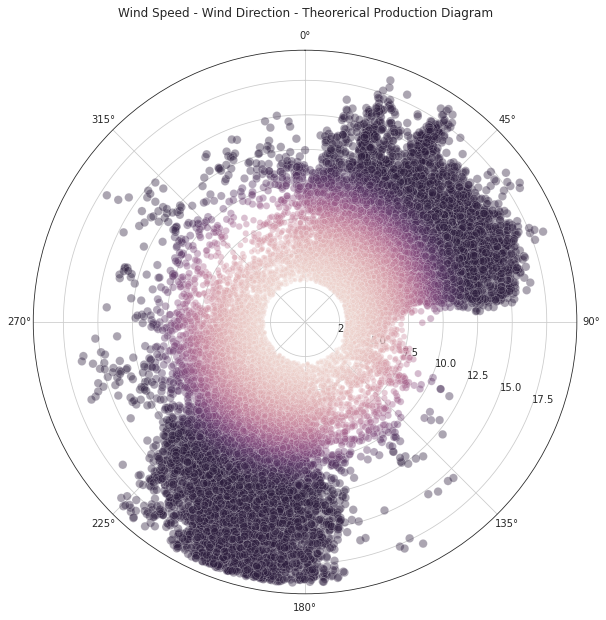

In [28]:
#Create the polar diagram for Theoretical Power production as function of wind features
plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)
sns.scatterplot(x=[radians(x) for x in df_or['wind direction (°)']], 
                y=df_or['wind speed (m/s)'],
                size=df_or['theoretical_power_curve (kwh)'],
                hue=df_or['theoretical_power_curve (kwh)'],
                alpha=0.4, legend=None)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Theorerical Production Diagram')
plt.ylabel(None)

Most of the records present a predominant wind direction between 170-225°, and 15-90°, showing the highest wind speed values (wind speed > 3 m/s). This finding is in good agreement with the observation shown in the following plot.

Text(0.5, 0, 'Wind direction (°)')

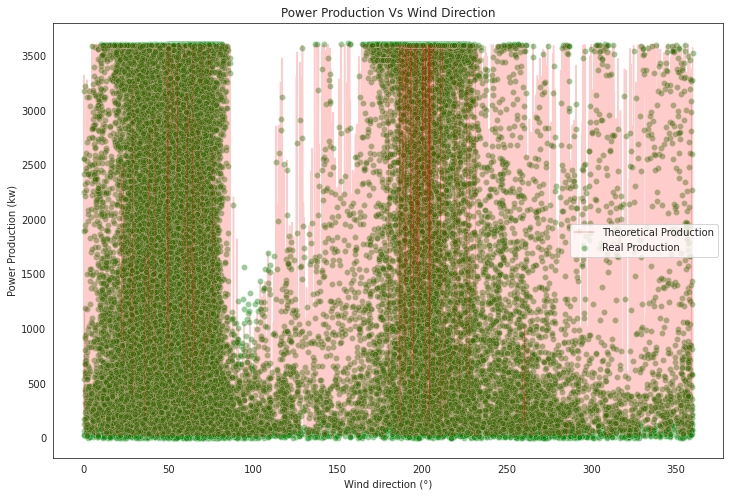

In [29]:
plt.figure(figsize=(12,8))

#scatter plot
sns.scatterplot(x='wind direction (°)', y='lv activepower (kw)', color='green', label='Real Production', alpha=0.4, data=df_or)

#lineplot
sns.lineplot(x='wind direction (°)', y='theoretical_power_curve (kwh)', color='red', label='Theoretical Production', alpha=0.2, data=df_or)
plt.title('Power Production Vs Wind Direction')
plt.ylabel('Power Production (kw)')
plt.xlabel('Wind direction (°)')

In [30]:
#target label
df_or['label'] = df_or['lv activepower (kw)']

df_or.head()

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour,min,label
0,01 01 2018 00:00,380.05,5.31,416.33,259.99,1,0,0,380.05
1,01 01 2018 00:10,453.77,5.67,519.92,268.64,1,0,10,453.77
2,01 01 2018 00:20,306.38,5.22,390.90,272.56,1,0,20,306.38
3,01 01 2018 00:30,419.65,5.66,516.13,271.26,1,0,30,419.65
4,01 01 2018 00:40,380.65,5.58,491.70,265.67,1,0,40,380.65


#4. Data Modeling

#4.1. Data processing

SparkMllib envolves the vectorization of features, as well the target label.
- **Target Label:** Real power production (`lv activepower (kw)`).
- **Features:** `month`, `hour`, `wind speed (m/s)`, and `wind direciton (°)`.


In [31]:
#Feature vectorization
from pyspark.ml.feature import VectorAssembler

df_spark =spark.createDataFrame(df_or) #to spark datatrame

#Features selected
selected_features = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vector_assembler = VectorAssembler(inputCols = selected_features, outputCol = 'features')
va_df = vector_assembler.transform(df_spark)

#Combine features and label column
df_final = va_df.select('features', 'label')
df_final.show(5) #spark dataframe

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
+--------------------+----------------+
only showing top 5 rows



#4.2. Train test split

In [32]:
train_test_split = df_final.randomSplit([0.8,0.2])

df_train = train_test_split[0]
df_test = train_test_split[1]

#Datasets size (wind speed: 3-18.88 m/s)
print('Train Dataset: ', df_train.count())
print('Test Dataset: ', df_test.count())

Train Dataset:  30798
Test Dataset:  7857


#4.2. Model

##4.2.1. Gradient-Boosted Trees (GBTs)
In this project, Gradient-Boosted Trees (GBTs) learning algorithm for regression is employed (Spark Library). This algorithms supports both continuous and categorical features. More information can be found in [Apache Spark](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html#pyspark.ml.regression.GBTRegressor).

In [33]:
from pyspark.ml.regression import GBTRegressor
#Define model
gbm = GBTRegressor(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
gbm_model = gbm.fit(df_train)

#Prediction using the test data
y_pred = gbm_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|248.946304321289| 347.9407285801919|
|281.934387207031| 347.9407285801919|
| 346.68569946289|347.79794097107646|
| 429.36538696289| 356.1735782317071|
|402.391998291015|497.83795720801413|
| 453.76919555664|497.83795720801413|
|685.547424316406| 537.9174072647535|
|825.766174316406| 791.6031948957192|
|932.308410644531| 791.6031948957192|
|1176.72399902343|1130.1443359869675|
+----------------+------------------+
only showing top 10 rows



Different metrics can be employed to determine the model accuracy. In this work, `RegressionEvaluator` is employed, with R2, MAE, and RMSE, as metrics. MAE represents the mean absolute difference between the real and predicted value. Meanwhile, RMSE represents the square root of mean squared difference between the real and predicted power production.

In [34]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.973408876605555
MAE      :  99.22490157956219
RMSE     :  202.44969166936878


R2 score indicates that 97.3% of real power production variability can be explained by the developed ML model.

##4.2.2. Generalized Linear Regression

In [35]:
from pyspark.ml.regression import GeneralizedLinearRegression

#Define model
glr = GeneralizedLinearRegression(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
glr_model = glr.fit(df_train)

#Prediction using the test data
y_pred = glr_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|248.946304321289|315.02013540200255|
|281.934387207031| 355.5542655575973|
| 346.68569946289|395.33611416415806|
| 429.36538696289|509.28109557313564|
|402.391998291015| 543.4877400332268|
| 453.76919555664| 565.8726424819595|
|685.547424316406|  720.212735226884|
|825.766174316406| 867.0785024485524|
|932.308410644531| 882.8086403227178|
|1176.72399902343|1108.3446338983738|
+----------------+------------------+
only showing top 10 rows



In [36]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.8899157820968489
MAE      :  283.64488281958916
RMSE     :  411.91850978413777


##4.2.3. Decision Tree Regressor

In [37]:
from pyspark.ml.regression import DecisionTreeRegressor
#Define model
dtr = DecisionTreeRegressor(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
dtr_model = dtr.fit(df_train)

#Prediction using the test data
y_pred = dtr_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|248.946304321289| 294.6704286195911|
|281.934387207031| 294.6704286195911|
| 346.68569946289| 294.6704286195911|
| 429.36538696289| 403.4681424993793|
|402.391998291015| 403.4681424993793|
| 453.76919555664|486.89810572726174|
|685.547424316406| 618.3326762383724|
|825.766174316406| 762.2860865659112|
|932.308410644531| 762.2860865659112|
|1176.72399902343| 958.3101561671754|
+----------------+------------------+
only showing top 10 rows



In [38]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9617107097058859
MAE      :  123.39363549374742
RMSE     :  242.93351572589182


#4.2.4. Random Forest Regressor


In [39]:
from pyspark.ml.regression import RandomForestRegressor
#Define model
rfr = RandomForestRegressor(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
rfr_model = rfr.fit(df_train)

#Prediction using the test data
y_pred = rfr_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|248.946304321289|  456.113479822696|
|281.934387207031|  456.113479822696|
| 346.68569946289|  456.113479822696|
| 429.36538696289| 462.8312950826474|
|402.391998291015| 495.4791572574795|
| 453.76919555664| 495.4791572574795|
|685.547424316406| 625.4410187689766|
|825.766174316406| 774.7002459504762|
|932.308410644531| 774.7002459504762|
|1176.72399902343|1155.9668515848996|
+----------------+------------------+
only showing top 10 rows



In [40]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9503668898689172
MAE      :  184.49330793584033
RMSE     :  276.58875662785596


##4.2.5. Linear Regression

In [41]:
from pyspark.ml.regression import LinearRegression
#Define model
lr = LinearRegression(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
lr_model = lr.fit(df_train)

#Prediction using the test data
y_pred = lr_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|248.946304321289|315.02013540200255|
|281.934387207031| 355.5542655575973|
| 346.68569946289|395.33611416415806|
| 429.36538696289|509.28109557313564|
|402.391998291015| 543.4877400332268|
| 453.76919555664| 565.8726424819595|
|685.547424316406|  720.212735226884|
|825.766174316406| 867.0785024485524|
|932.308410644531| 882.8086403227178|
|1176.72399902343|1108.3446338983738|
+----------------+------------------+
only showing top 10 rows



In [42]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.8899157820968489
MAE      :  283.64488281958916
RMSE     :  411.91850978413777


##4.2.6. FM Regressor

In [43]:
from pyspark.ml.regression import FMRegressor
#Define model
FMr = FMRegressor(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
FMr_model = FMr.fit(df_train)

#Prediction using the test data
y_pred = FMr_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|248.946304321289|  1651.82981891892|
|281.934387207031|1712.8167496475053|
| 346.68569946289|1629.4150286850713|
| 429.36538696289|  933.133578814628|
|402.391998291015| 2016.262009631797|
| 453.76919555664|2068.2447646294477|
|685.547424316406| 416.6327785351459|
|825.766174316406|  1622.77448312573|
|932.308410644531|1665.4265048831135|
|1176.72399902343| 1603.675275516377|
+----------------+------------------+
only showing top 10 rows



In [44]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.6006162762816885
MAE      :  590.2612140066592
RMSE     :  784.5921487864821


##4.2.7. Isotonic Regression

In [45]:
from pyspark.ml.regression import IsotonicRegression
#Define model
ir = IsotonicRegression(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
ir_model = ir.fit(df_train)

#Prediction using the test data
y_pred = ir_model.transform(df_test)

#Target and predicted values comparison
y_pred.select('label', 'prediction').show(10)

+----------------+----------------+
|           label|      prediction|
+----------------+----------------+
|248.946304321289|687.107177734375|
|281.934387207031|687.107177734375|
| 346.68569946289|687.107177734375|
| 429.36538696289|687.107177734375|
|402.391998291015|687.107177734375|
| 453.76919555664|687.107177734375|
|685.547424316406|687.107177734375|
|825.766174316406|687.107177734375|
|932.308410644531|687.107177734375|
|1176.72399902343|687.107177734375|
+----------------+----------------+
only showing top 10 rows



In [46]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  -0.14450081395551861
MAE      :  1135.828342862178
RMSE     :  1328.1796748501592


**Conclusion:** The best performance metrics were obtained using Gradient-Boosted Trees (GBTs), followed by Regression Evaluator.

#5. Predicted and real values comparison

In [51]:
gbm = GBTRegressor(featuresCol='features', labelCol='label') #features vector

#Fit the data and train the model
gbm_model = gbm.fit(df_train)

#Prediction using the test data
y_pred = gbm_model.transform(df_test)

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.973408876605555
MAE      :  99.22490157956219
RMSE     :  202.44969166936878


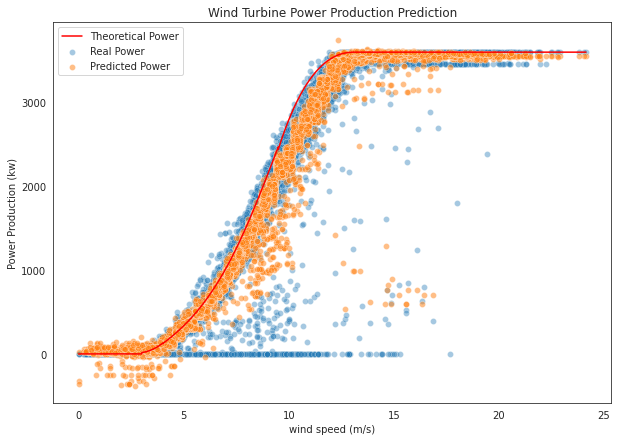

In [55]:
#Convert df_sample to Spark dataframe
eva_df = spark.createDataFrame(df_sample)

# Converting lv activepower (kw) variable as target label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

#Define features/variables
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [df_sample[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.4, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.5, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoretical Power',color='red', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();

**Credits:** [Melih Akdag](https://www.kaggle.com/code/akdagmelih/wind-turbine-power-prediction-gbtregressor-pyspark)